# The behaviours of (logit)binarycrossentopy
https://github.com/FluxML/Flux.jl/issues/914

In [1]:
using Flux
using Plots
using Measures

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/apple/.julia/packages/CUDAdrv/mCr0O/src/CUDAdrv.jl:69


## Binarycrossentropy and logitbinarycrossentropy

In Flux.jl, the definitions of binarycrossentropy and logitbinarycrossentopy are
\begin{align}
\text{binarycrossentropy}(\hat{y}, y) & = -y\log(\hat{y} + \epsilon)-(1-y)\log(1-\hat{y} + \epsilon), \epsilon = \text{eps}(\hat{y}) \\ 
\text{logitbinarycrossentropy}(\log\hat{y}, y) & = (1-y)\log \hat{y} - \log\sigma (\log\hat{y})
\end{align}
https://github.com/FluxML/Flux.jl/blob/master/src/layers/stateless.jl#L37  
https://github.com/FluxML/Flux.jl/blob/master/src/layers/stateless.jl#L54

For $x \in \text{Float32},$ sigmoid function is defined as 
\begin{align}
\sigma(x) & = 
    \begin{cases}
        0, & x < -80 \\ 
        \frac{1}{1 + e^{-x}}, & \text{otherwise}
    \end{cases}
\end{align}
https://github.com/FluxML/NNlib.jl/blob/master/src/activation.jl#L15

In [2]:
xs_float32 = collect(Float32, 0:50);
xs_float64 = collect(Float64, 0:50);

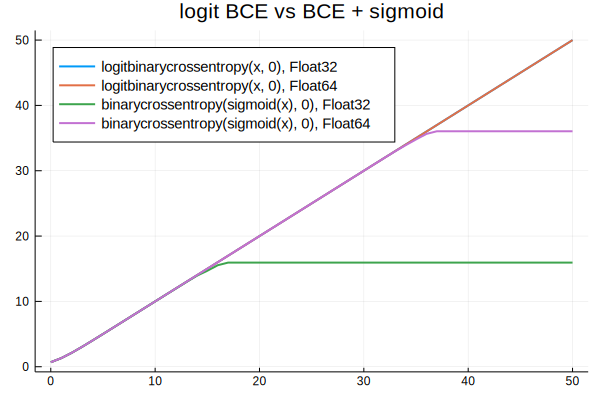

In [3]:
plot(legend = :topleft, legendfontsize = 10, title = "logit BCE vs BCE + sigmoid")
plot!(xs_float32, Flux.logitbinarycrossentropy.(xs_float32, 0), 
    label = "logitbinarycrossentropy(x, 0), Float32", lw = 2)
plot!(xs_float64, Flux.logitbinarycrossentropy.(xs_float64, 0), 
    label = "logitbinarycrossentropy(x, 0), Float64", lw = 2)
plot!(xs_float32, Flux.binarycrossentropy.(sigmoid.(xs_float32), 0), 
    label = "binarycrossentropy(sigmoid(x), 0), Float32", lw = 2)
plot!(xs_float64, Flux.binarycrossentropy.(sigmoid.(xs_float64), 0), 
    label = "binarycrossentropy(sigmoid(x), 0), Float64", lw = 2)

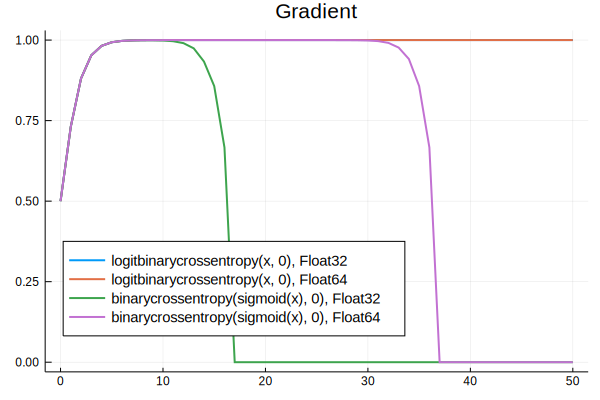

In [4]:
plot(legend = :bottomleft, legendfontsize = 10, title = "Gradient")
ys = getindex.(gradient.(x->Flux.logitbinarycrossentropy(x, 0), xs_float32), 1)
plot!(xs_float32, ys, label = "logitbinarycrossentropy(x, 0), Float32", lw = 2)
ys = getindex.(gradient.(x->Flux.logitbinarycrossentropy(x, 0), xs_float64), 1)
plot!(xs_float64, ys, label = "logitbinarycrossentropy(x, 0), Float64", lw = 2)
ys = getindex.(gradient.(x->Flux.binarycrossentropy.(sigmoid.(x), 0), xs_float32), 1)
plot!(xs_float32, ys, label = "binarycrossentropy(sigmoid(x), 0), Float32", lw = 2)
ys = getindex.(gradient.(x->Flux.binarycrossentropy.(sigmoid.(x), 0), xs_float64), 1)
plot!(xs_float64, ys, label = "binarycrossentropy(sigmoid(x), 0), Float64", lw = 2)

## What's happened?

In [5]:
f1(x) = one(x) + exp(-x) - one(x)

f1 (generic function with 1 method)

In [6]:
function search_min_root_f1(x_l, x_r)
    while true
        x_mid = (x_l + x_r) * oftype(x_l, 0.5)
        if f1(x_mid) > zero(x_l)
            x_l = x_mid
        else
            x_r = x_mid
        end

#         println(x_l, ",", x_r)
        if nextfloat(x_l) == x_r
            return x_l
        end
    end
end

search_min_root_f1 (generic function with 1 method)

In [7]:
x_32 = search_min_root_f1(16f0, 17f0)

16.63553f0

In [8]:
1f0 + exp(-x_32), 1f0 + exp(-nextfloat(x_32))

(1.0000001f0, 1.0f0)

In [9]:
x_64 = search_min_root_f1(30.0, 40.0)

36.7368005696771

In [10]:
1.0 + exp(-x_64), 1.0 + exp(-nextfloat(x_64))

(1.0000000000000002, 1.0)

In [11]:
xs = nextfloat.(x_32, -5:5)

11-element Array{Float32,1}:
 16.63552 
 16.635523
 16.635525
 16.635527
 16.635529
 16.63553 
 16.635532
 16.635534
 16.635536
 16.635538
 16.63554 

In [12]:
gradient.(sigmoid, xs)

11-element Array{Tuple{Float32},1}:
 (1.19209275e-7,)
 (1.19209275e-7,)
 (1.19209275e-7,)
 (1.19209275e-7,)
 (1.19209275e-7,)
 (1.19209275e-7,)
 (0.0,)          
 (0.0,)          
 (0.0,)          
 (0.0,)          
 (0.0,)          

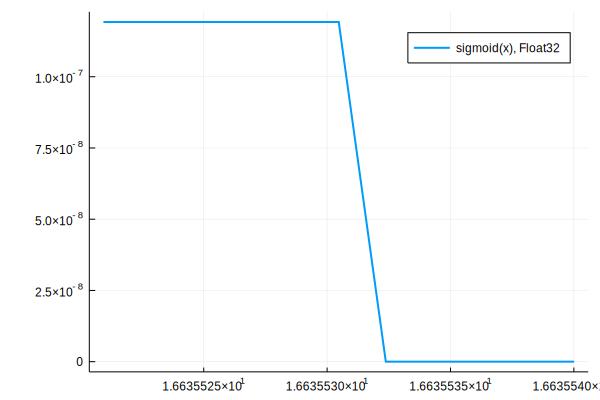

In [13]:
plot(xs, getindex.(gradient.(sigmoid, xs), 1),
    label = "sigmoid(x), Float32", lw = 2)

In [18]:
# Original definition

# @adjoint function σ(x::Real)
#     y = σ(x)
#     return y, Δ -> (Δ * y * (1 - y),)
# end

mysigmoid(x::Real) = one(x) / (one(x) + exp(-x))

Flux.@adjoint function mysigmoid(x::Real)
    y = mysigmoid(x)
    z = ifelse(y == one(y), prevfloat(one(x)), y)
    w = z * (1 - z)
    return y, Δ -> (Δ * w,)
end

Flux.Zygote.refresh()

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


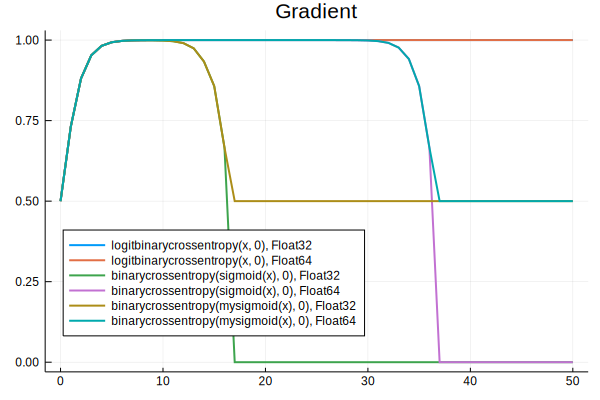

In [19]:
plot(legend = :bottomleft, legendfontsize = 8, title = "Gradient")
ys = getindex.(gradient.(x->Flux.logitbinarycrossentropy(x, 0), xs_float32), 1)
plot!(xs_float32, ys, label = "logitbinarycrossentropy(x, 0), Float32", lw = 2)
ys = getindex.(gradient.(x->Flux.logitbinarycrossentropy(x, 0), xs_float64), 1)
plot!(xs_float64, ys, label = "logitbinarycrossentropy(x, 0), Float64", lw = 2)
ys = getindex.(gradient.(x->Flux.binarycrossentropy.(sigmoid.(x), 0), xs_float32), 1)
plot!(xs_float32, ys, label = "binarycrossentropy(sigmoid(x), 0), Float32", lw = 2)
ys = getindex.(gradient.(x->Flux.binarycrossentropy.(sigmoid.(x), 0), xs_float64), 1)
plot!(xs_float64, ys, label = "binarycrossentropy(sigmoid(x), 0), Float64", lw = 2)
ys = getindex.(gradient.(x->Flux.binarycrossentropy.(mysigmoid.(x), 0), xs_float32), 1)
plot!(xs_float32, ys, label = "binarycrossentropy(mysigmoid(x), 0), Float32", lw = 2)
ys = getindex.(gradient.(x->Flux.binarycrossentropy.(mysigmoid.(x), 0), xs_float64), 1)
plot!(xs_float64, ys, label = "binarycrossentropy(mysigmoid(x), 0), Float64", lw = 2)